# Kaggle's VSB Powerline Fault Detection

In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set()

import re 

from tsfresh.feature_extraction import extract_features

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import dslab
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Bruno\Anaconda3\envs\DSlab\python.exe
{'numpy': '1.16.4', 'pandas': '0.23.4', 'seaborn': '0.9.0', 'sklearn': '0.21.2', 'matplotlib': '3.1.1'}


In [2]:
dict([(m.__name__, m.__version__) for m in [np, pd, sns, sklearn, matplotlib]])

{'numpy': '1.16.4',
 'pandas': '0.23.4',
 'seaborn': '0.9.0',
 'sklearn': '0.21.2',
 'matplotlib': '3.1.1'}

## Load and Visualize the Data

### Load and view the structure of the train data

In [3]:
dftrain = pd.read_csv("./data/DS19hn0_cm0_train.csv")
dftrain = dftrain.apply(pd.to_numeric)
dftrain.shape

(800000, 4)

In [4]:
dftrain.head()

,time,P0,P1,P2
0,0,18,1,-19
1,1,18,0,-19
2,2,17,-1,-20
3,3,18,1,-19
4,4,18,0,-19


In [5]:
dftrain['P0'].head()

0    18
1    18
2    17
3    18
4    18
Name: P0, dtype: int64

In [6]:
dftrain['time'].tail()

799995    799995
799996    799996
799997    799997
799998    799998
799999    799999
Name: time, dtype: int64

#### Make a copy of the train data with a time unit of milliseconds for plotting:

In [7]:
dftrain2 = dftrain.copy()
dftrain2['time'] = dftrain2['time'].apply(lambda x: x * 20 / 800000)
dftrain2['time'].head()
dftrain2['time'].tail()

799995    19.999875
799996    19.999900
799997    19.999925
799998    19.999950
799999    19.999975
Name: time, dtype: float64

### Load and view the structure of the test data

In [8]:
dftest = pd.read_csv("./data/DS19hn0_cm0_test.csv")
dftest.shape

(800000, 4)

In [9]:
dftest.head()

,time,P0,P1,P2
0,0,-16,-5,19
1,1,-17,-6,19
2,2,-17,-6,19
3,3,-16,-5,20
4,4,-16,-5,20


### Make a copy of the test data with a time unit of milliseconds for plotting:

In [10]:
dftest2 = dftest.copy()
dftest2['time'] = dftest2['time'].apply(lambda x: x * 20 / 800000)
dftest2['time'].head()
dftest2['time'].tail()

799995    19.999875
799996    19.999900
799997    19.999925
799998    19.999950
799999    19.999975
Name: time, dtype: float64

### Plot the train time series data:

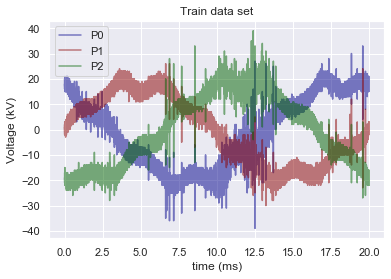

In [11]:
fig, ax = plt.subplots(1, 1)
dftrain2.plot(x='time', y='P0', c='darkblue', ax=ax, alpha=0.5)
dftrain2.plot(x='time', y='P1', c='darkred', ax=ax, alpha=0.5)
dftrain2.plot(x='time', y='P2', c='darkgreen', ax=ax, alpha=0.5)
plt.ylabel('Voltage (kV)')
plt.xlabel('time (ms)')
plt.title('Train data set');

### Plot the test time series data:

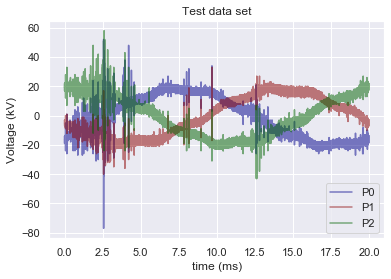

In [12]:
fig, ax = plt.subplots(1, 1)
dftest2.plot(x='time', y='P0', c='darkblue', ax=ax, alpha=0.5)
dftest2.plot(x='time', y='P1', c='darkred', ax=ax, alpha=0.5)
dftest2.plot(x='time', y='P2', c='darkgreen', ax=ax, alpha=0.5)
plt.ylabel('Voltage (kV)')
plt.xlabel('time (ms)')
plt.title('Test data set');

### Describe the data and compare the two data sets:
#### As can be seen in the plots above, a larger range of values were recorded for the Voltage in the test set in comparison to the train set due to outliers, excluding extreme values, both signals have an amplitude of approximately 20 kV. There also appears to be a phase difference between the underlying signals in the train and test data.


## Characterize the Normal Dynamics

### Divide the train data time series into episodes of 1000 samples by adding an id column 

In [13]:
# dftrain2 = dftrain
dftrain['id'] = np.array(dftrain['time']/1000, np.integer)
dftrain['time'].head()

# dftrain.shape

0    0
1    1
2    2
3    3
4    4
Name: time, dtype: int64

In [14]:
print(dftrain.id.unique())

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

### Feature Extraction:

#### Use tsfresh for feature extraction - feature_extraction function inputs flat dataframe, specifying different timeseries samples by id and sorting them by time. The function extracts features without hypothesis testing and feature selection.

#### SKIP BELOW CELLS
#### Code to extract features from the train data set using a subset of the instances to quickly test extracted features:

In [ ]:
mask = dftrain['id'] < 3
dftrain[mask].head()

In [ ]:
df_train_features = extract_features(dftrain[mask], column_id="id", column_sort="time")

#### SKIP BELOW CELL - Code to extract features from the train data set using all of the instances: Note this is included for completeness only - should  to load pre-computed train features from file.


In [ ]:
df_train_features = extract_features(dftrain, column_id="id", column_sort="time")

#### SKIP BELOW CELL, DO NOT EXECUTE it unless feature extraction has been successfully performed using the above cell
#### Write features extracted from the train data set to file to save needing to recompute them in future (caching)

In [ ]:
df_train_features.to_csv(path_or_buf='C:/Users/Bruno/dslab/DS19hn4_0_features.csv', index=True)

#### Load extracted features from the train data set from file:

In [15]:
df_train_features = pd.read_csv('train_features/DS19hn4_0_features.csv')

### Expected dimensionality of matrix of features extracted from train data set: 

In [16]:
df_train_features.shape

(800, 2383)

#### The shape produced by the cell above is as expected as it should contain a little less than 3*794 columns (three columns for each feature extracted by tsfresh i.e. 1 for each signal P0, P1, P2), plus 1 column containing the id assigned to the row, and 800 rows - one for each group of 1000 samples in the original data set.

In [17]:
df_train_features.head()

,id,P0__abs_energy,P0__absolute_sum_of_changes,"P0__agg_autocorrelation__f_agg_""mean""__maxlag_40","P0__agg_autocorrelation__f_agg_""median""__maxlag_40","P0__agg_autocorrelation__f_agg_""var""__maxlag_40","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""",...,P2__symmetry_looking__r_0.9,P2__symmetry_looking__r_0.9500000000000001,P2__time_reversal_asymmetry_statistic__lag_1,P2__time_reversal_asymmetry_statistic__lag_2,P2__time_reversal_asymmetry_statistic__lag_3,P2__value_count__value_-1,P2__value_count__value_0,P2__value_count__value_1,P2__variance,P2__variance_larger_than_standard_deviation
0,0,322657.0,1050.0,0.000937,0.005460,0.070894,19.077030,0.061168,0.001272,0.002097,...,1.0,1.0,-0.710421,0.649598,1.429577,0.0,0.0,0.0,0.731311,0.0
1,1,316661.0,1143.0,0.019957,0.016382,0.090415,18.791089,0.296152,0.006241,0.002033,...,1.0,1.0,1.472946,3.613454,2.923541,0.0,0.0,0.0,0.754956,0.0
2,2,319929.0,1070.0,0.049906,0.027824,0.073309,19.565743,-0.522693,-0.009409,0.001550,...,1.0,1.0,-1.611222,-3.030120,-4.726358,0.0,0.0,0.0,0.815711,0.0
3,3,310010.0,1035.0,0.017522,0.006346,0.063800,18.462376,0.324850,0.006619,0.001947,...,1.0,1.0,1.507014,1.570281,0.528169,0.0,0.0,0.0,0.773679,0.0
4,4,312146.0,1194.0,0.016309,0.022138,0.087407,19.296832,-0.302490,-0.006199,0.001973,...,1.0,1.0,-0.774549,-1.692771,-3.615694,0.0,0.0,0.0,0.908391,0.0


#### Set the index of the dataframe to id and drop features that evaluated to NAN values:

In [18]:
df_train_features = df_train_features.set_index('id')

In [19]:
train_cols = df_train_features.dropna(axis=1).columns
print(train_cols)

Index(['P0__abs_energy', 'P0__absolute_sum_of_changes',
       'P0__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'P0__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'P0__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
       ...
       'P2__symmetry_looking__r_0.9',
       'P2__symmetry_looking__r_0.9500000000000001',
       'P2__time_reversal_asymmetry_statistic__lag_1',
       'P2__time_reversal_asymmetry_statistic__lag_2',
       'P2__time_reversal_asymmetry_statistic__lag_3',
       'P2__value_count__value_-1', 'P2__value_count__value_0',
       'P2__value_count__value_1', 'P2__variance',
       'P2__va

## Analyze the Test Set Data:

### Workaround: Extract features from test data set now 
#### This is done here to use the non NAN features from the test data set to fit the scalar and PCA models using the train data set

### Divide the test data time series into episodes of 1000 samples by adding an id column 

In [20]:
dftest['id'] = np.array(dftrain['time']/1000, np.integer)
dftest['time'].head()

0    0
1    1
2    2
3    3
4    4
Name: time, dtype: int64

### Code to extract features from the test data set

#### SKIP BELOW CELLS
#### Code to extract features from the test data set using a subset of the instances to quickly test extracted features:

In [ ]:
mask = dftest['id'] < 3
dftest[mask].head()

In [ ]:
df_test_features = extract_features(dftest[mask], column_id="id", column_sort="time")

### SKIP BELOW CELL to load pre-computed train features from file.
### Code to extract features from the test data set using all of the instances: Note this is included for completeness only

In [ ]:
df_test_features = extract_features(dftrain, column_id="id", column_sort="time")

### SKIP THIS CELL, DO NOT EXECUTE it unless feature extraction has been successfully performed using the above cell
### Write features extracted from the test data set to file to save needing to recompute them in future (caching)

In [ ]:
df_test_features.to_csv(path_or_buf='C:/Users/Bruno/dslab/DS19hn5_0_features.csv', index=True)

### Load extracted features from the test data set from file:

In [22]:
df_test_features = pd.read_csv('test_features/DS19hn5_0_features.csv')

### Expected dimensionality of matrix of features extracted from test data set: 

In [23]:
df_test_features.shape

(800, 2383)

#### The shape produced by the cell above is as expected as it should contain a little less than 3*794 columns (three columns for each feature extracted by tsfresh i.e. 1 for each signal P0, P1, P2), plus 1 column containing the id assigned to the row, and 800 rows - one for each group of 1000 samples in the original data set.

#### Set the index of the dataframe to id and drop features that evaluated to NAN values:

In [24]:
df_test_features = df_test_features.set_index('id')
df_test_features.head()

,P0__abs_energy,P0__absolute_sum_of_changes,"P0__agg_autocorrelation__f_agg_""mean""__maxlag_40","P0__agg_autocorrelation__f_agg_""median""__maxlag_40","P0__agg_autocorrelation__f_agg_""var""__maxlag_40","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","P0__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","P0__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,P2__symmetry_looking__r_0.9,P2__symmetry_looking__r_0.9500000000000001,P2__time_reversal_asymmetry_statistic__lag_1,P2__time_reversal_asymmetry_statistic__lag_2,P2__time_reversal_asymmetry_statistic__lag_3,P2__value_count__value_-1,P2__value_count__value_0,P2__value_count__value_1,P2__variance,P2__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,255915.0,593.0,0.105948,0.118053,0.101307,-15.216238,0.325020,0.006187,0.001818,-14.800000,...,1.0,1.0,0.734469,0.709839,2.346076,0.0,0.0,0.0,0.788199,0.0
1,251079.0,488.0,0.043310,0.048267,0.055768,-14.710891,-0.217754,-0.004224,0.001913,-14.285714,...,1.0,1.0,-1.686373,-5.644578,-6.267606,0.0,0.0,0.0,0.603484,0.0
2,241992.0,497.0,0.044879,0.056299,0.009552,-14.956238,0.177860,0.007399,0.004135,-14.542857,...,1.0,1.0,-1.260521,-0.243976,-1.457746,0.0,0.0,0.0,0.840976,0.0
3,243080.0,571.0,0.083463,0.121070,0.092745,-14.960000,0.374922,0.009091,0.002271,-14.457143,...,1.0,1.0,0.801603,0.801205,-0.851107,0.0,0.0,0.0,0.734400,0.0
4,233103.0,595.0,0.039974,0.077369,0.118891,-14.200594,0.121757,0.002436,0.002006,-13.500000,...,1.0,1.0,-0.740481,0.724900,1.583501,0.0,0.0,0.0,0.813375,0.0


In [25]:
test_cols = df_test_features.dropna(axis=1).columns
print(test_cols)

Index(['P0__abs_energy', 'P0__absolute_sum_of_changes',
       'P0__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'P0__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'P0__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
       ...
       'P2__symmetry_looking__r_0.9',
       'P2__symmetry_looking__r_0.9500000000000001',
       'P2__time_reversal_asymmetry_statistic__lag_1',
       'P2__time_reversal_asymmetry_statistic__lag_2',
       'P2__time_reversal_asymmetry_statistic__lag_3',
       'P2__value_count__value_-1', 'P2__value_count__value_0',
       'P2__value_count__value_1', 'P2__variance',
       'P2__va

## Continue Analysing the train and test set data:

### Fit the scalar transormer and PCA model on the train data, and scale the train data prior to fitting the PCA model on the train data. However, only use the features in the test set that are non NAN for both train and test sets:

In [26]:
# fit transform objects PCA and standard scalar only on train set

scaler = StandardScaler()
scaler.fit(df_train_features[test_cols])

df_train_features_s = scaler.transform(df_train_features[test_cols])

pca = PCA(n_components=200, random_state=0)
pca.fit(df_train_features_s)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

### Transform the features extracted from the train data into the principle component space:

In [27]:
X_train_s = pca.transform(df_train_features_s)

### Visualize the train data set in the first and second principle component subspace:

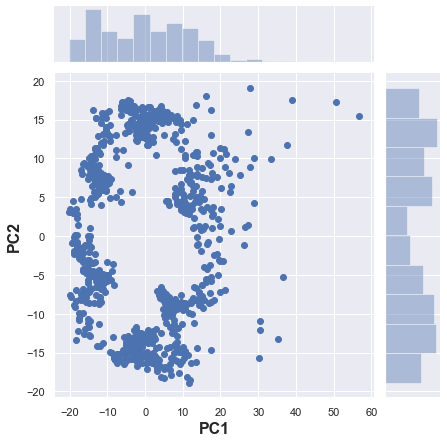

In [84]:
ax = sns.jointplot(X_train_s[:,0], X_train_s[:,1])
ax.set_axis_labels('PC1', 'PC2', fontsize=16, fontweight='bold')

### Description of the above scatter plot:

#### The plot above show that the first principle component (plotted on the x axis) roughly follows a bimodal distribution. The second principle component follows a multi-modal distribution. The resultant scatter plots of the data, when in the space of the first and second principle components therefore roughly follows an elipse. However, some data points are outliers, these have first principle component values that are approximately over 20. 

### Get the features dominating the first principle component:

#### Plot feature coefficients for PC1:

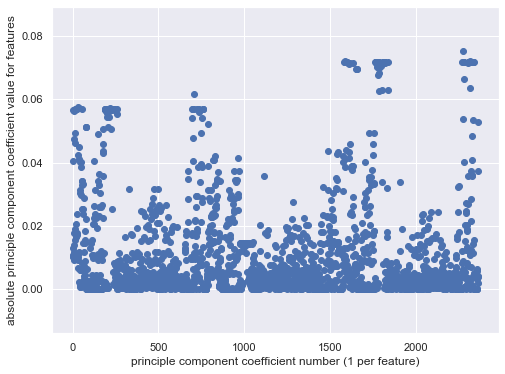

In [90]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(0,pca.components_.shape[1]), np.abs(pca.components_[0]))
plt.xlabel('principle component coefficient number (1 per feature)')
plt.ylabel('absolute principle component coefficient value for features');

#### Print the most important features for PC1 as defined by a threshold: the PC value is greater than 0.0718 (note - value may need tuning each run). The threshold is selected to get a reasonable number of features.

In [36]:
PC1_most_important_features = test_cols[np.argsort(-pca.components_[0])[np.where(np.abs(pca.components_[0]) > 0.0718)]]
print(PC1_most_important_features)

Index(['P1__fft_coefficient__coeff_98__attr_"imag"',
       'P2__energy_ratio_by_chunks__num_segments_10__segment_focus_4',
       'P0__fft_coefficient__coeff_27__attr_"real"',
       'P0__approximate_entropy__m_2__r_0.9',
       'P0__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
       'P0__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20',
       'P0__quantile__q_0.6'],
      dtype='object')


### Get the features dominating the second principle component:

#### Plot feature coefficients for PC2:

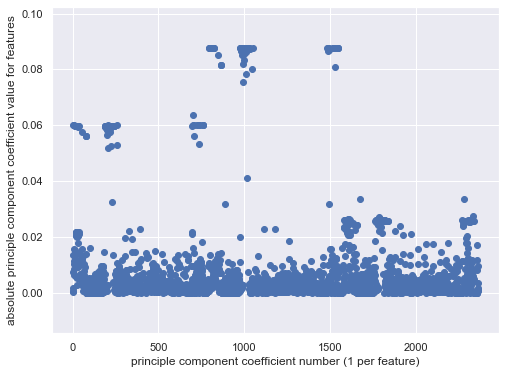

In [91]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(0,pca.components_.shape[1]), np.abs(pca.components_[1]))
plt.xlabel('principle component coefficient number (1 per feature)')
plt.ylabel('absolute principle component coefficient value for features');

#### Print the most important features for PC2 as defined by a threshold: the PC value is greater than 0.08775. The threshold is selected to get a reasonable number of features.

In [39]:
print(test_cols[np.argsort(-pca.components_[1])[np.where(np.abs(pca.components_[1]) > 0.08775)]])

Index(['P0__first_location_of_maximum',
       'P2__fft_coefficient__coeff_43__attr_"real"',
       'P0__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6',
       'P0__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'P1__fft_coefficient__coeff_78__attr_"real"',
       'P2__fft_coefficient__coeff_75__attr_"abs"',
       'P0__fft_coefficient__coeff_42__attr_"angle"'],
      dtype='object')


### Scale the features extracted from the test data set using the standard deviation and mean of the train data set.

In [43]:
df_test_features_s = scaler.fit_transform(df_test_features[test_cols]) 

### Transform the scaled features extracted from the test dataset into the principle component space.

In [44]:
X_test_s = pca.transform(df_test_features_s)

### Visualize the test data set in the first and second principle component subspace:

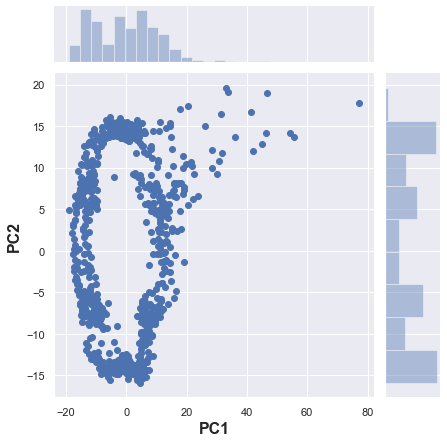

In [86]:
ax = sns.jointplot(X_test_s[:,0], X_test_s[:,1])
ax.set_axis_labels('PC1', 'PC2', fontsize=16, fontweight='bold')

### Description of the scatter plot and the main differences between this plot and the corresponding one for the train data set:

#### The plot above show that the first principle component (plotted on the x axis) roughly follows a bimodal distribution. The second principle component follows a multi-modal distribution. The resultant scatter plots of the data, when in the space of the first and second principle components therefore roughly follows an elipse. However, some data points are outliers, these have first principle component values that are approximately over 20, and second principle component values that are approximately over 5. 
#### Like the train data set, data points in the test data set with first principle component values of over 20 are outliers, however, unlike the train data set, only data points with second principle component values of over 5 are outliers. Data points in the train data set appear to potentially be outliers regardless of the value of the second principle component values, although more data is needed to test that hypothesis.
#### As can be seen from the plots of the first and second principle components for both the train and test datasets, the values for the first principle component in the test data set also have a larger range than those in the train data. 
#### The scatter plot of these principle components for the train data also reveal a more noisy elipse than that seen in the plot of the principle components for the test data. This is due to the more complex, noisy distributions of the principle components in the train data.

### Indications of partial discharge and when they occur in terms of principle components:

#### Indications of partial discharge approximately occur when PC values are above thresholds i.e. when PC1 is approximately greater than 20 for both train and test data sets, for the test set PC2 must also approximately be greater than 5 - see the above plots.

#### Note that this definition of partial discharge could be improved by calculating the distance of points from a normal to an elipse fitted to the PC1 data when plotted against the PC2 data.

### Indications of partial discharge and when they occur in terms of extracted time series features:

#### PC1 most significantly corresponds to fast fourier transform coefficients, entropy, energy ratios, cwt coefficients, quantiles, and change quantiles and PC2 most significantly corresponds to fast fourier transform coefficients and change quantiles.

#### The features with the highest contribution to the first principle component (as defined earlier) are plotted below:

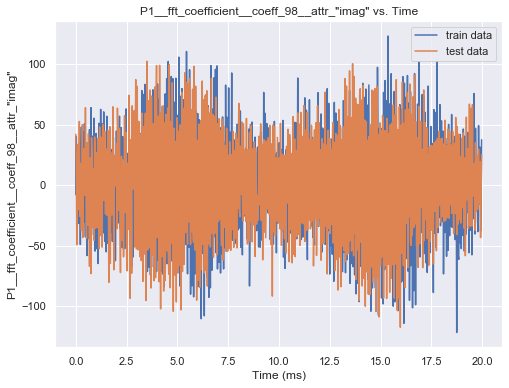

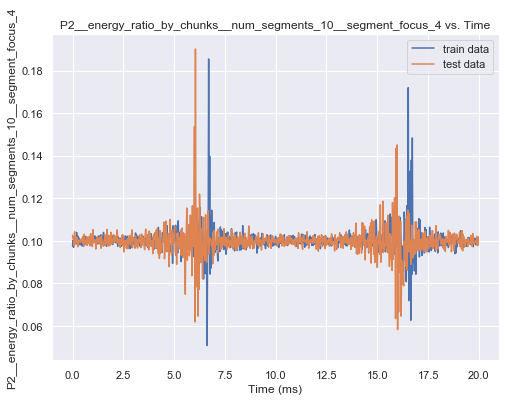

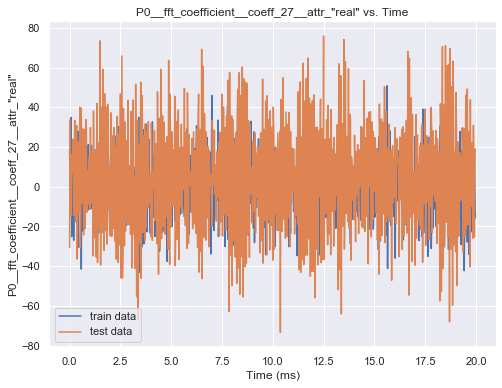

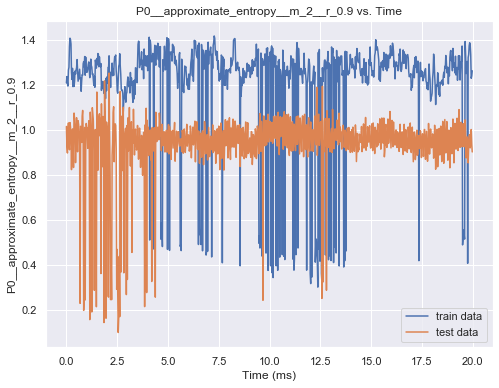

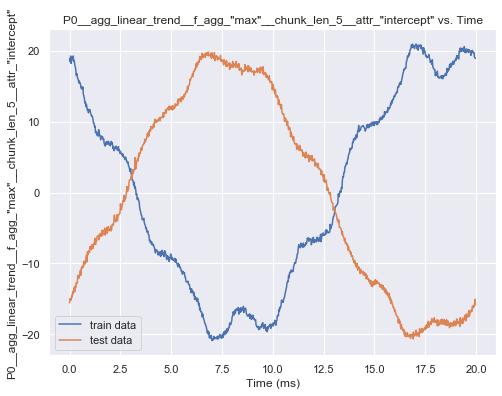

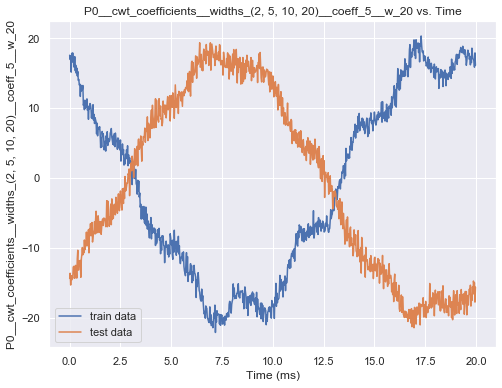

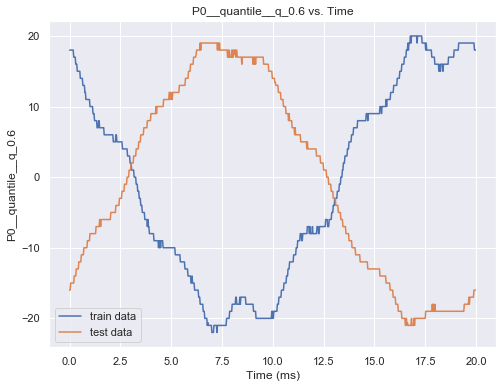

In [76]:
for i, f in enumerate(PC1_most_important_features):
    plt.figure(i,figsize=(8, 6))
    plt.title(str(f) + ' vs. Time')
    plt.xlabel('Time (ms)')
    plt.ylabel(str(f))
    plt.plot(pd.to_numeric(df_train_features.index)/800*20, df_train_features[str(f)], label='train data')
    plt.plot(pd.to_numeric(df_test_features.index)/800*20, df_test_features[str(f)], label='test data')
    plt.legend()

#### The above plots show that a number of the important features (particularly the P1__fft_coefficient__coeff_98__attr_"imag" and P2__energy_ratio_by_chunks__num_segments_10__segment_focus_4 features) have the greatest amplitude between 5 to 7 ms and 15 to 17 ms.  Some of the other signals appear to possibly be cyclic with large absolute values appearing after approximately 0 ms, between 7 and 11 ms, and between 17.5 and 20 ms. The absolute values for important features for both signals are generally similar although there are some biases between the two e.g. the approximately .3 difference that can be seen in the mean of the P0__approximate_entropy__m_2__r_0.9 signal for the train and test data sets. However the spikes in the P2__energy_ratio_by_chunks__num_segments_10__segment_focus_4 signal that occur after 6 and 16 ms, are most the clearest indication from an energy measure of an abnormal change and are therefore these times are likely when the paritial discharge events occured.  